In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
import subprocess

In [3]:
#getting files from server from server
# sudo tailscale up before running
def get_kid_timestreams(four_kid_num):
    #four_kid_num must be of the format xxxx, i.e 0001, 0150, 1001
    print(f'Downloading i timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/i_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    print(f'Downloading q timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/q_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    return

In [4]:
kid_nums = ['0120', '0140', '0150', '0160']

# for i in kid_nums:
#     get_kid_timestreams(i)

In [6]:
#importing from dirfiles

#locations and folder
dir_base = '/home/triv/Desktop/localBLASTTNG/'
dir_master = dir_base + 'master_2020-01-06-06-21-22'
dir_roach3 = dir_base + 'roach3_2020-01-06-06-21-56'

roach_num = 3 #using roach 3 rn

mode_dirfile = gd.RDONLY
data_master = gd.dirfile(dir_master, mode_dirfile)
data_roach3 = gd.dirfile(dir_roach3)

#getting data
RAm = data_master.getdata(b'RA')
DECm = data_master.getdata(b'DEC')
master_time = data_master.getdata(b'TIME') + data_master.getdata(b'TIME_USEC')*1e-6
roach_time = data_roach3.getdata(b'ctime_built_roach3')

#detectors

many_phase_vals = []
many_absIQ_vals = []
for n,k_num in enumerate(kid_nums):
    I_vals = data_roach3.getdata(f"i_kid{k_num}_roach3".encode('UTF-8'))
    Q_vals = data_roach3.getdata(f"q_kid{k_num}_roach3".encode('UTF-8'))
    many_absIQ_vals.append(np.sqrt(I_vals**2 + Q_vals**2))
    many_phase_vals.append(np.arctan2(Q_vals, I_vals))

many_absIQ_vals = np.array(many_absIQ_vals)
many_phase_vals = np.array(many_phase_vals)

In [7]:
def view_data():
    m_diff = np.diff(master_time)
    r_diff = np.diff(roach_time)
    print('RA & DEC shape: ', RAm.shape, DECm.shape)
    print(f"Detector array shape: {many_phase_vals.shape}")
    print('Master time: ')
    print(f"    min: {np.min(master_time)}, max: {np.max(master_time)}, avg. diff: {np.mean(m_diff)}, clock speed: {1/np.mean(m_diff)}")
    print('Detector time: ')
    print(f"    min: {np.min(roach_time)}, max: {np.max(roach_time)}, avg. diff: {np.median(r_diff)}, clock speed: {1/np.median(r_diff)}")
    return
view_data()

RA & DEC shape:  (9830900,) (9830900,)
Detector array shape: (4, 46531631)
Master time: 
    min: 1578244880.069792, max: 1578343189.25718, avg. diff: 0.010000020078320739, clock speed: 99.99979921719574
Detector time: 
    min: 1578244917.5798242, max: 1578342886.964096, avg. diff: 0.002048015594482422, clock speed: 488.27753201396973


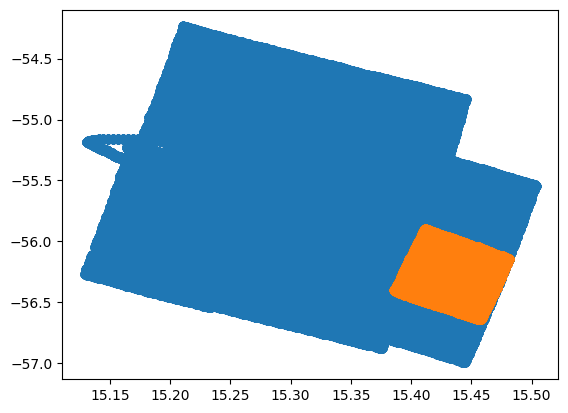

In [8]:
#setting scan area from RA and DEC master arrays
start = int(7.85e6)
stop = int(7.9722e6)

def show_scan_area():
    plt.scatter(RAm[7000000:7972200], DECm[7000000:7972200])
    plt.scatter(RAm[start:stop], DECm[start:stop])
    plt.show()
show_scan_area()

In [10]:
#Scaling Master and Detector arrays by time
DETinds = np.array([np.searchsorted(roach_time, t, side='left') for t in master_time]) #finds closest index in roach time for each master time
DETinds[DETinds == len(roach_time)] = len(roach_time) - 1 # fixed max index bug from np.searchsorted

#Scaled arrays (can be used with each other)
RA = RAm[start:stop]
DEC = DECm[start:stop]
PH = many_phase_vals[:,DETinds][:,start:stop]
AMP = many_absIQ_vals[:,DETinds][:,start:stop]

print(RA.shape, DEC.shape, PH.shape, AMP.shape)

(122200,) (122200,) (4, 122200) (4, 122200)


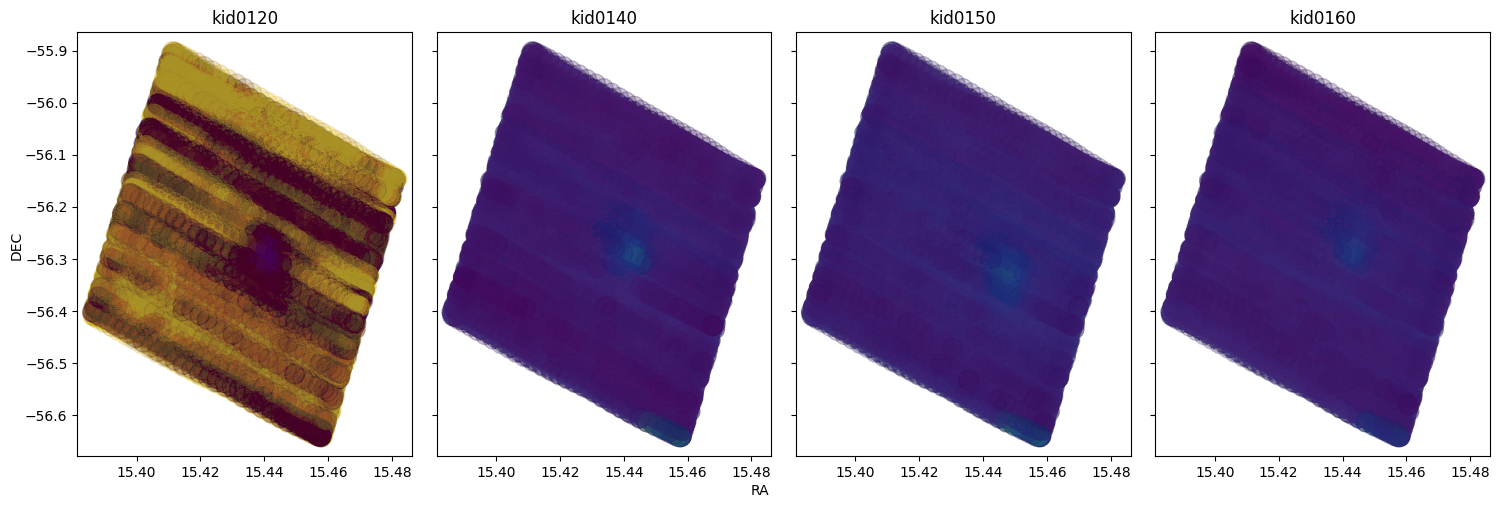

In [11]:
#Simple scatter map from detector
def multi_phase_scatter_map():
    fig, axs = plt.subplots(1, len(kid_nums), sharex=True, sharey=True, figsize=(15,5))
    for i,ax in enumerate(axs):
        a = ax.scatter(RA,DEC,c=PH[i],alpha=0.01, s=200)
        ax.set_title(f'kid{kid_nums[i]}')
    fig.text(0.5, 0, 'RA', ha='center')
    fig.text(0, 0.5, 'DEC', va='center', rotation='vertical')
    plt.tight_layout()
multi_phase_scatter_map()

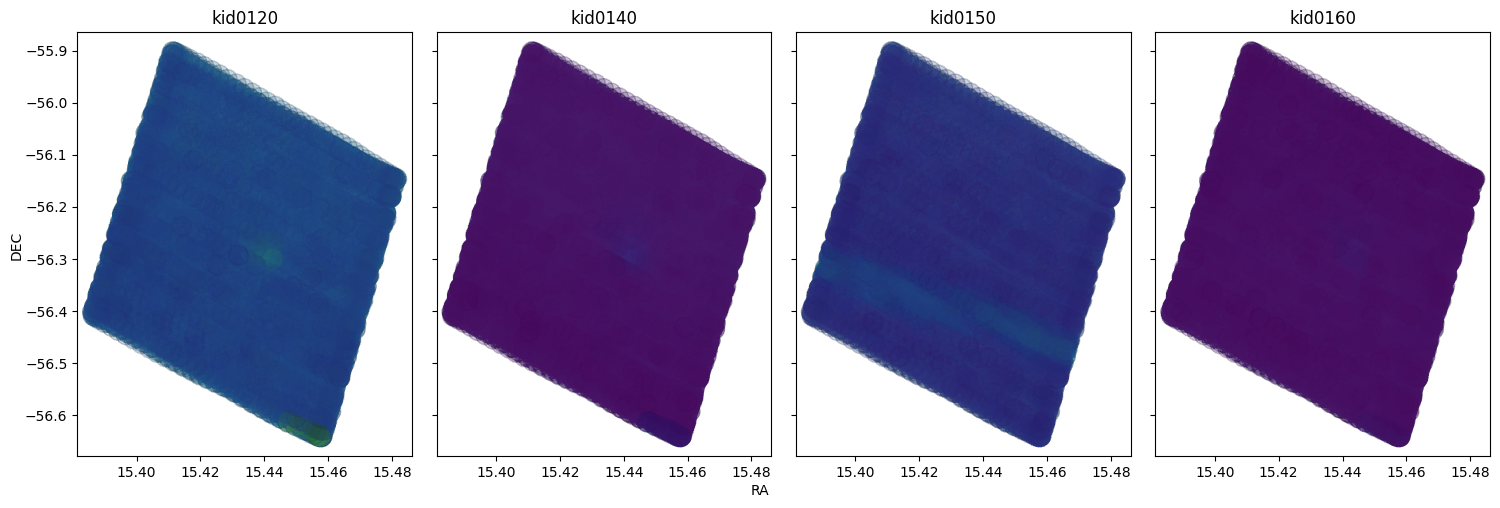

In [12]:
def multi_amp_scatter_map():
    fig, axs = plt.subplots(1, len(kid_nums), sharex=True, sharey=True, figsize=(15,5))
    for i,ax in enumerate(axs):
        a = ax.scatter(RA,DEC,c=AMP[i],alpha=0.01, s=200)
        ax.set_title(f'kid{kid_nums[i]}')
    fig.text(0.5, 0, 'RA', ha='center')
    fig.text(0, 0.5, 'DEC', va='center', rotation='vertical')
    plt.tight_layout()
multi_amp_scatter_map()

In [13]:
#Build map array from pixels
ra_bin = 0.0025
dec_bin = 0.02
r_pix = np.arange(np.min(RA), np.max(RA), ra_bin)
d_pix = np.arange(np.min(DEC), np.max(DEC), dec_bin)

rr, dd = np.meshgrid(r_pix,d_pix)

#populate map

def fill_coverage_map():
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            pix_val = det_inds.sum() #counts ra&dec for each pixel
            Z[i,j] = pix_val 
    return Z
 
def fill_map(datastream, kid_n):
    """datastream : PH or AMPS"""
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            det_vals = datastream[kid_n, det_inds] #phase values at each pixel from ts
            pix_val = np.mean(det_vals)
            Z[i,j] = pix_val
    return Z

cov_map = fill_coverage_map()

phase_map = np.array([fill_map(PH, kn) for kn in range(len(kid_nums))])
amp_map = np.array([fill_map(AMP, kn) for kn in range(len(kid_nums))])

/home/triv/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/triv/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


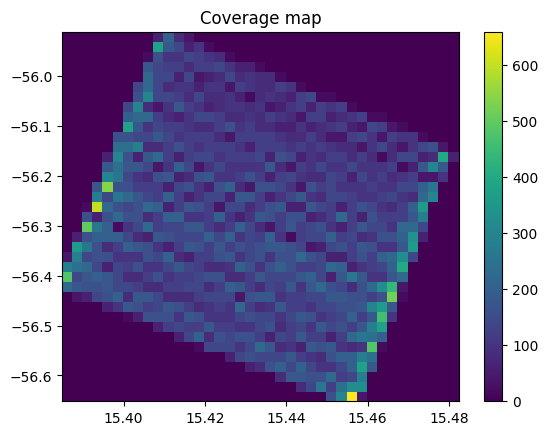

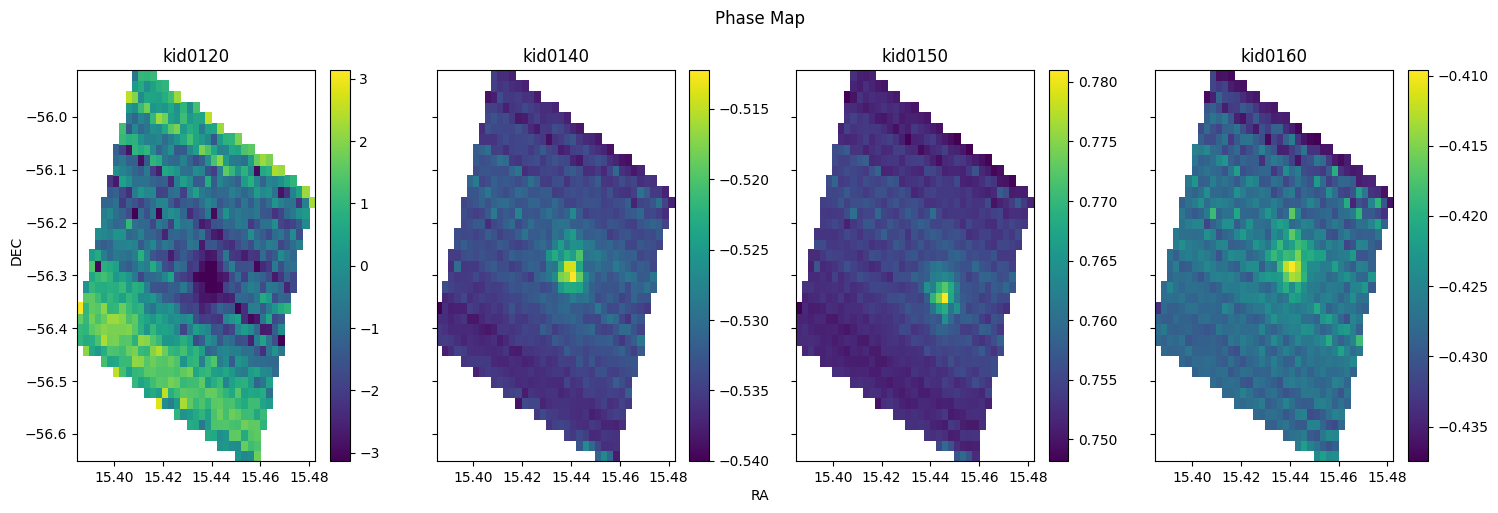

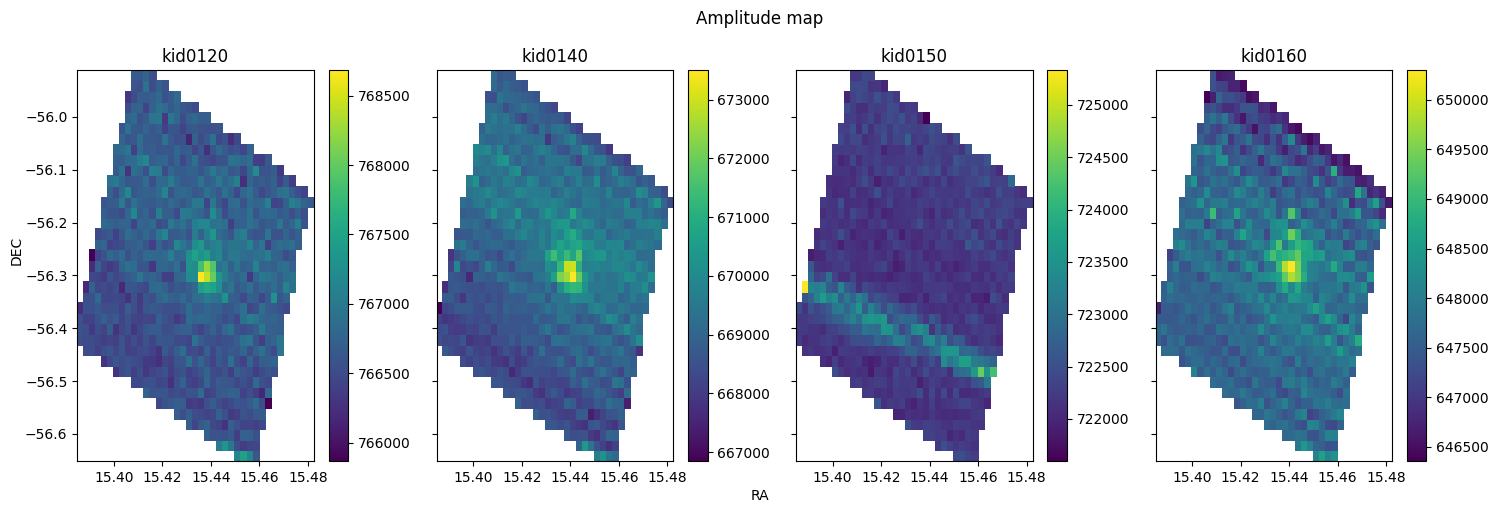

In [14]:
def show_multi_maps():
    plt.pcolor(rr,dd,cov_map)
    plt.title('Coverage map')
    plt.colorbar()
    plt.show()
    
    fig, axs = plt.subplots(1, len(kid_nums), sharex=True, sharey=True, figsize=(15,5))
    for i,ax in enumerate(axs):
        a = ax.pcolor(rr,dd,phase_map[i])
        ax.set_title(f'kid{kid_nums[i]}')
        fig.colorbar(a)
    fig.text(0.5, 0, 'RA', ha='center')
    fig.text(0, 0.5, 'DEC', va='center', rotation='vertical')
    fig.suptitle("Phase Map")
    plt.tight_layout()

    fig, axs = plt.subplots(1, len(kid_nums), sharex=True, sharey=True, figsize=(15,5))
    for i,ax in enumerate(axs):
        a = ax.pcolor(rr,dd,amp_map[i])
        ax.set_title(f'kid{kid_nums[i]}')
        fig.colorbar(a)
    fig.text(0.5, 0, 'RA', ha='center')
    fig.text(0, 0.5, 'DEC', va='center', rotation='vertical')
    fig.suptitle("Amplitude map")
    plt.tight_layout()
show_multi_maps()